## Load dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:512'

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import json
import os
import numpy as np
import random
import cv2

transform =  transforms.Compose([
    transforms.ToTensor()
])

class InpaintingDataset(Dataset):
    def __init__(self,
            train,
            root_path='/content/drive/MyDrive/Postgrado/Dataset/landmarks/landmarks',
            masks_number=4):
        self.masks_number=masks_number
        self.root_dir       = f'{root_path}/{"train" if train else "test"}/statue/'
        self.root_landmarks = f'{root_path}/{"train" if train else "test"}/statues128landmarks.json'

        with open(self.root_landmarks) as fp:
            self.landmark_points = json.load(fp)
        self.image_paths = []
        self.landmarks = []
        self.train = train

        filenames = os.listdir(self.root_dir)
        filenames = [filename for filename in filenames if filename.split('.')[1] in ('jpg', 'jpeg', 'png')]
        filenames = sorted(filenames, key=lambda fn: int(fn.split('.')[0]))
        for filename in filenames:
            path_to_img = os.path.join(self.root_dir, filename)
            self.image_paths.append(path_to_img)
            landmark = self.get_image_landmark(filename)
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def get_image_landmark(self, filename):
        landmark = []
        for num in range(68):
            x_coordinate = int(self.landmark_points[filename][str(num)]['x'])
            y_coordinate = int(self.landmark_points[filename][str(num)]['y'])
            landmark.append([x_coordinate, y_coordinate])
        return landmark

    #@staticmethod
    def create_mask(self, image):
        img_height, img_width = image.shape[0:2]
        min_mask_w, max_mask_w = 10, 30
        min_mask_h, max_mask_h = 10, 30
        mask = np.zeros((img_height, img_width))
        for i in range(self.masks_number):
          mask_x = random.randint(0, 128 - max_mask_w)
          mask_width = random.randint(min_mask_w, max_mask_w)
          mask_y = random.randint(0, 128 - max_mask_h)
          mask_height = random.randint(min_mask_h, max_mask_h)
          mask[mask_y:mask_y + mask_height, mask_x:mask_x + mask_width] = 1
        return mask

    def __getitem__(self, index):
        image = cv2.imread(self.image_paths[index])
        img_tensor = transform(image)

        landmarks = self.landmarks[index]
        landmarks = landmarks - 0.5
        landmarks = np.expand_dims(landmarks, axis=0)
        landmarks_tensor = torch.from_numpy(landmarks)

        mask = self.create_mask(image)
        mask_tensor = transform(mask)
        return img_tensor.to(device), landmarks_tensor.to(device), mask_tensor.to(device)

In [ ]:
train_dataset = InpaintingDataset(train = True)
test_dataset = InpaintingDataset(train = False)

torch.Size([1, 68, 2])


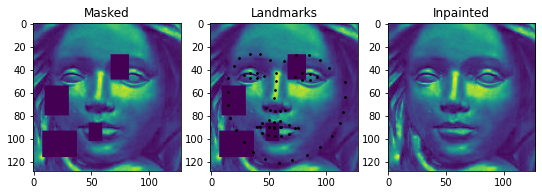

torch.Size([1, 68, 2])


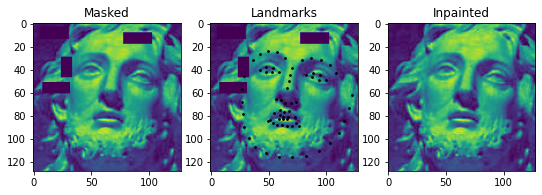

torch.Size([1, 68, 2])


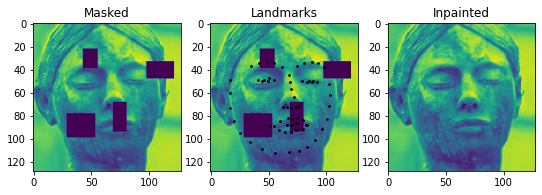

In [ ]:
from matplotlib import pyplot as plt
for i in range(3):
    image1, landmarks1, mask1 = train_dataset[i+200]
    
    print(landmarks1.shape)

    f = plt.figure(figsize=(9, 4))
    
    img = image1[0].cpu()
    lmk = landmarks1[0].cpu()
    msk = mask1[0].cpu()
  
    masked_img = img * (1 - msk)
    
    ax1 = f.add_subplot(1,3, 1)
    ax1.set_title('Masked')
    plt.imshow(masked_img)

    ax2 = f.add_subplot(1,3, 2)
    ax2.set_title('Landmarks')
    plt.imshow(masked_img)
    plt.scatter(lmk[:, 0], lmk[:, 1], s=3, c='black')


    ax3 = f.add_subplot(1,3, 3)
    ax3.set_title('Inpainted')
    plt.imshow(img)
    
    plt.show(block=True)

## Loss

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
#from torch.utils.data.dataloader import pin_memory_batch

class AdversarialLoss(nn.Module):
    r"""
    Adversarial loss
    https://arxiv.org/abs/1711.10337
    """

    def __init__(self, type='nsgan', target_real_label=1.0, target_fake_label=0.0):
        r"""
        type = nsgan | lsgan | hinge
        """
        super(AdversarialLoss, self).__init__()

        self.type = type
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))

        if type == 'nsgan':
            self.criterion = nn.BCELoss()

        elif type == 'lsgan':
            self.criterion = nn.MSELoss()

        elif type == 'hinge':
            self.criterion = nn.ReLU()

    def __call__(self, outputs, is_real, is_disc=None):
        if self.type == 'hinge':
            if is_disc:
                if is_real:
                    outputs = -outputs
                return self.criterion(1 + outputs).mean()
            else:
                return (-outputs).mean()

        else:
            labels = (self.real_label if is_real else self.fake_label).expand_as(outputs)
            loss = self.criterion(outputs, labels)
            return loss


class StyleLoss(nn.Module):
    r"""
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self):
        super(StyleLoss, self).__init__()
        self.add_module('vgg', VGG19())
        self.criterion = torch.nn.L1Loss()

    def compute_gram(self, x):
        b, ch, h, w = x.size()
        f = x.view(b, ch, w * h)
        f_T = f.transpose(1, 2)
        G = f.bmm(f_T) / (h * w * ch)

        return G

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)

        # Compute loss
        style_loss = 0.0
        style_loss += self.criterion(self.compute_gram(x_vgg['relu2_2']), self.compute_gram(y_vgg['relu2_2']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu3_4']), self.compute_gram(y_vgg['relu3_4']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu4_4']), self.compute_gram(y_vgg['relu4_4']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu5_2']), self.compute_gram(y_vgg['relu5_2']))

        return style_loss



class PerceptualLoss(nn.Module):
    r"""
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self, weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
        super(PerceptualLoss, self).__init__()
        self.add_module('vgg', VGG19())
        self.criterion = torch.nn.L1Loss()
        self.weights = weights

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)

        content_loss = 0.0
        content_loss += self.weights[0] * self.criterion(x_vgg['relu1_1'], y_vgg['relu1_1'])
        content_loss += self.weights[1] * self.criterion(x_vgg['relu2_1'], y_vgg['relu2_1'])
        content_loss += self.weights[2] * self.criterion(x_vgg['relu3_1'], y_vgg['relu3_1'])
        content_loss += self.weights[3] * self.criterion(x_vgg['relu4_1'], y_vgg['relu4_1'])
        content_loss += self.weights[4] * self.criterion(x_vgg['relu5_1'], y_vgg['relu5_1'])


        return content_loss



class VGG19(torch.nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        features = models.vgg19(pretrained=True).features
        self.relu1_1 = torch.nn.Sequential()
        self.relu1_2 = torch.nn.Sequential()

        self.relu2_1 = torch.nn.Sequential()
        self.relu2_2 = torch.nn.Sequential()

        self.relu3_1 = torch.nn.Sequential()
        self.relu3_2 = torch.nn.Sequential()
        self.relu3_3 = torch.nn.Sequential()
        self.relu3_4 = torch.nn.Sequential()

        self.relu4_1 = torch.nn.Sequential()
        self.relu4_2 = torch.nn.Sequential()
        self.relu4_3 = torch.nn.Sequential()
        self.relu4_4 = torch.nn.Sequential()

        self.relu5_1 = torch.nn.Sequential()
        self.relu5_2 = torch.nn.Sequential()
        self.relu5_3 = torch.nn.Sequential()
        self.relu5_4 = torch.nn.Sequential()

        for x in range(2):
            self.relu1_1.add_module(str(x), features[x])

        for x in range(2, 4):
            self.relu1_2.add_module(str(x), features[x])

        for x in range(4, 7):
            self.relu2_1.add_module(str(x), features[x])

        for x in range(7, 9):
            self.relu2_2.add_module(str(x), features[x])

        for x in range(9, 12):
            self.relu3_1.add_module(str(x), features[x])

        for x in range(12, 14):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(14, 16):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(16, 18):
            self.relu3_4.add_module(str(x), features[x])

        for x in range(18, 21):
            self.relu4_1.add_module(str(x), features[x])

        for x in range(21, 23):
            self.relu4_2.add_module(str(x), features[x])

        for x in range(23, 25):
            self.relu4_3.add_module(str(x), features[x])

        for x in range(25, 27):
            self.relu4_4.add_module(str(x), features[x])

        for x in range(27, 30):
            self.relu5_1.add_module(str(x), features[x])

        for x in range(30, 32):
            self.relu5_2.add_module(str(x), features[x])

        for x in range(32, 34):
            self.relu5_3.add_module(str(x), features[x])

        for x in range(34, 36):
            self.relu5_4.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        relu1_1 = self.relu1_1(x)
        relu1_2 = self.relu1_2(relu1_1)

        relu2_1 = self.relu2_1(relu1_2)
        relu2_2 = self.relu2_2(relu2_1)

        relu3_1 = self.relu3_1(relu2_2)
        relu3_2 = self.relu3_2(relu3_1)
        relu3_3 = self.relu3_3(relu3_2)
        relu3_4 = self.relu3_4(relu3_3)

        relu4_1 = self.relu4_1(relu3_4)
        relu4_2 = self.relu4_2(relu4_1)
        relu4_3 = self.relu4_3(relu4_2)
        relu4_4 = self.relu4_4(relu4_3)

        relu5_1 = self.relu5_1(relu4_4)
        relu5_2 = self.relu5_2(relu5_1)
        relu5_3 = self.relu5_3(relu5_2)
        relu5_4 = self.relu5_4(relu5_3)

        out = {
            'relu1_1': relu1_1,
            'relu1_2': relu1_2,

            'relu2_1': relu2_1,
            'relu2_2': relu2_2,

            'relu3_1': relu3_1,
            'relu3_2': relu3_2,
            'relu3_3': relu3_3,
            'relu3_4': relu3_4,

            'relu4_1': relu4_1,
            'relu4_2': relu4_2,
            'relu4_3': relu4_3,
            'relu4_4': relu4_4,

            'relu5_1': relu5_1,
            'relu5_2': relu5_2,
            'relu5_3': relu5_3,
            'relu5_4': relu5_4,
        }
        return out

class TVLoss(nn.Module):
    def __init__(self):
        super(TVLoss,self).__init__()

    def forward(self, x):
        height = x.size()[2]
        width = x.size()[3]
        tv_h = torch.div(torch.sum(torch.abs(x[:,:,1:,:] - x[:,:,:-1,:])),(x.size()[0]*x.size()[1]*(height-1)*width))
        tv_w = torch.div(torch.sum(torch.abs(x[:,:,:,1:] - x[:,:,:,:-1])),(x.size()[0]*x.size()[1]*(height)*(width-1)))
        return tv_w+tv_h


## Networks EdgeConnect

In [ ]:
import torch
import torch.nn as nn


class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''

        def init_func(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)

                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

            elif classname.find('BatchNorm2d') != -1:
                nn.init.normal_(m.weight.data, 1.0, gain)
                nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)


class InpaintGenerator(BaseNetwork):
    def __init__(self, residual_blocks=8, init_weights=True):
        super(InpaintGenerator, self).__init__()

        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=7, padding=0),
            nn.InstanceNorm2d(64, track_running_stats=False),
            nn.ReLU(False),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128, track_running_stats=False),
            nn.ReLU(False),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, track_running_stats=False),
            nn.ReLU(False)
        )

        blocks = []
        for _ in range(residual_blocks):
            block = ResnetBlock(256, 2)
            blocks.append(block)

        self.middle = nn.Sequential(*blocks)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128, track_running_stats=False),
            nn.ReLU(False),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64, track_running_stats=False),
            nn.ReLU(False),

            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, padding=0),
        )

        if init_weights:
            self.init_weights()

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        x = (torch.tanh(x) + 1) / 2
        return x

class Discriminator(BaseNetwork):
    def __init__(self, in_channels, use_sigmoid=True, use_spectral_norm=True, init_weights=True):
        super(Discriminator, self).__init__()
        self.use_sigmoid = use_sigmoid

        self.conv1 = self.features = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv2 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv3 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv4 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv5 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
        )

        if init_weights:
            self.init_weights()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        outputs = conv5
        if self.use_sigmoid:
            outputs = torch.sigmoid(conv5)

        return outputs, [conv1, conv2, conv3, conv4, conv5]


class ResnetBlock(nn.Module):
    def __init__(self, dim, dilation=1, use_spectral_norm=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(dilation),
            spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=0, dilation=dilation, bias=not use_spectral_norm), use_spectral_norm),
            nn.InstanceNorm2d(dim, track_running_stats=False),
            nn.ReLU(False),

            nn.ReflectionPad2d(1),
            spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=0, dilation=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.InstanceNorm2d(dim, track_running_stats=False),
        )

    def forward(self, x):
        out = x + self.conv_block(x)

        # Remove ReLU at the end of the residual block
        # http://torch.ch/blog/2016/02/04/resnets.html

        return out


def spectral_norm(module, mode=True):
    if mode:
        return nn.utils.spectral_norm(module)

    return module

## Networks Lafin

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F


class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''

        def init_func(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)

                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

            elif classname.find('BatchNorm2d') != -1:
                nn.init.normal_(m.weight.data, 1.0, gain)
                nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)


class InpaintGenerator(BaseNetwork):
    def __init__(self, residual_blocks=7, init_weights=True):
        super(InpaintGenerator, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=7, padding=0),
            nn.InstanceNorm2d(64, track_running_stats=False),
            nn.ReLU(False)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128, track_running_stats=False),
            nn.ReLU(False),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, track_running_stats=False),
            nn.ReLU(False)
        )

        self.fushion1 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1),
            nn.InstanceNorm2d(256,track_running_stats=False),
            nn.ReLU(False)
        )

        self.fushion2 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=1),
            nn.InstanceNorm2d(128,track_running_stats=False),
            nn.ReLU(False)
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128, track_running_stats=False),
            nn.ReLU(False),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64, track_running_stats=False),
            nn.ReLU(False),
        )

        self.decoder3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=128, out_channels=3, kernel_size=7, padding=0),
        )

        blocks = []
        for _ in range(residual_blocks):
            block = ResnetBlock(256, 2)
            blocks.append(block)

        self.middle = nn.Sequential(*blocks)

        self.auto_attn = Auto_Attn(input_nc=256, norm_layer=None)

        if init_weights:
            self.init_weights()


    def forward(self, x, mask_whole, mask_half, mask_quarter):

        f_e1 = self.encoder1(x)
        f_e2 = self.encoder2(f_e1)
        f_e3 = self.encoder3(f_e2)
        x = self.middle(f_e3)
        #x, _ = self.auto_attn(x, f_e3, mask_quarter)
        x = self.decoder1(x)
        x = self.fushion1(torch.cat((f_e2*(1-mask_half),x),dim=1))
        x = self.decoder2(x)
        x = self.fushion2(torch.cat((f_e1*(1-mask_whole),x),dim=1))
        x = self.decoder3(x)
        x = (torch.tanh(x) + 1) / 2

        return x



class Discriminator(BaseNetwork):
    def __init__(self, in_channels, use_sigmoid=True, use_spectral_norm=True, init_weights=True):
        super(Discriminator, self).__init__()
        self.use_sigmoid = use_sigmoid

        self.conv1 = self.features = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv2 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv3 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv4 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv5 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
        )

        self.auto_attn = Auto_Attn(input_nc=128,norm_layer=None)
        if init_weights:
            self.init_weights()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        #conv2, _ = self.auto_attn(conv2, None)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        outputs = conv5
        if self.use_sigmoid:
            outputs = torch.sigmoid(conv5)

        return outputs, [conv1, conv2, conv3, conv4, conv5]


class ResnetBlock(nn.Module):
    def __init__(self, dim, dilation=1, use_spectral_norm=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(dilation),
            spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=0, dilation=dilation, bias=not use_spectral_norm), use_spectral_norm),
            nn.InstanceNorm2d(dim, track_running_stats=False),
            nn.ReLU(False),

            nn.ReflectionPad2d(1),
            spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=0, dilation=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.InstanceNorm2d(dim, track_running_stats=False),
        )

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


def spectral_norm(module, mode=True):
    if mode:
        return nn.utils.spectral_norm(module)

    return module


def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=False)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=False)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=False),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=False),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=False),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self,input_size=256, width_mult=1., points_num=68):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        #assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel

        self.features = nn.Sequential(*self.features)
        # building last several layers
        # make it nn.Sequential
        self.last_block = conv_1x1_bn(input_channel,self.last_channel)

        # building classifier
        self.conv1_after_mbnet = nn.Conv2d(1280,64,(1,1))
        self.conv_node1 = nn.Conv2d(320,128,(1,1))
        self.conv_node2 = nn.Conv2d(1280,128,(1,1))
        self.prelu = nn.PReLU()
        self.fc_landmark = nn.Linear(320, points_num*2)
        self._initialize_weights()


    def forward(self, images):

        x = self.features(images)     # C = 320
        node1 =  self.conv_node1(x)   # 1x1 conv 320-->128
        node1 = node1.mean(3).mean(2) # avgpool


        x = self.last_block(x)        # 1x1 conv 320 -->1280
        node2 = self.conv_node2(x)    # 1x1 conv 1280-->128
        node2 = node2.mean(3).mean(2) # avgpool

        x = F.avg_pool2d(x, (8, 8))    # avgpool
        x = self.conv1_after_mbnet(x)  # 1x1 conv 1280 --> 64
        x = torch.flatten(x,start_dim=1,end_dim=3)
        final = self.prelu(x)

        end = torch.cat([node1,node2,final],dim=1)

        landmark = self.fc_landmark(end)

        return landmark


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

class AddCoords(nn.Module):
    """
    Add Coords to a tensor
    """
    def __init__(self, with_r=False):
        super(AddCoords, self).__init__()
        self.with_r = with_r

    def forward(self, x):
        """
        :param x: shape (batch, channel, x_dim, y_dim)
        :return: shape (batch, channel+2, x_dim, y_dim)
        """
        B, _, x_dim, y_dim = x.size()

        # coord calculate
        xx_channel = torch.arange(x_dim).repeat(B, 1, y_dim, 1).type_as(x)
        yy_cahnnel = torch.arange(y_dim).repeat(B, 1, x_dim, 1).permute(0, 1, 3, 2).type_as(x)
        # normalization
        xx_channel = xx_channel.float() / (x_dim-1)
        yy_cahnnel = yy_cahnnel.float() / (y_dim-1)
        xx_channel = xx_channel * 2 - 1
        yy_cahnnel = yy_cahnnel * 2 - 1

        ret = torch.cat([x, xx_channel, yy_cahnnel], dim=1)

        if self.with_r:
            rr = torch.sqrt(xx_channel ** 2 + yy_cahnnel ** 2)
            ret = torch.cat([ret, rr], dim=1)

        return ret


class CoordConv(nn.Module):
    """
    CoordConv operation
    """
    def __init__(self, input_nc, output_nc, with_r=False, use_spect=False, **kwargs):
        super(CoordConv, self).__init__()
        self.addcoords = AddCoords(with_r=with_r)
        input_nc = input_nc + 2
        if with_r:
            input_nc = input_nc + 1
        self.conv = spectral_norm(nn.Conv2d(input_nc, output_nc, **kwargs), use_spect)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)

        return ret


def coord_conv(input_nc, output_nc, use_spect=False, use_coord=False, with_r=False, **kwargs):
    """use coord convolution layer to add position information"""

    if use_coord:
        return CoordConv(input_nc, output_nc, with_r, use_spect, **kwargs)
    else:
        return spectral_norm(nn.Conv2d(input_nc, output_nc, **kwargs), use_spect)



class ResBlock(nn.Module):
    """
    Define an Residual block for different types
    """
    def __init__(self, input_nc, output_nc, hidden_nc=None, norm_layer=nn.BatchNorm2d, nonlinearity= nn.LeakyReLU(),
                 sample_type='none', use_spect=False, use_coord=False):
        super(ResBlock, self).__init__()

        hidden_nc = output_nc if hidden_nc is None else hidden_nc
        self.sample = True
        if sample_type == 'none':
            self.sample = False
        elif sample_type == 'up':
            output_nc = output_nc * 4
            self.pool = nn.PixelShuffle(upscale_factor=2)
        elif sample_type == 'down':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError('sample type [%s] is not found' % sample_type)

        kwargs = {'kernel_size': 3, 'stride': 1, 'padding': 1}
        kwargs_short = {'kernel_size': 1, 'stride': 1, 'padding': 0}

        self.conv1 = coord_conv(input_nc, hidden_nc, use_spect, use_coord, **kwargs)
        self.conv2 = coord_conv(hidden_nc, output_nc, use_spect, use_coord, **kwargs)
        self.bypass = coord_conv(input_nc, output_nc, use_spect, use_coord, **kwargs_short)

        if type(norm_layer) == type(None):
            self.model = nn.Sequential(nonlinearity, self.conv1, nonlinearity, self.conv2,)
        else:
            self.model = nn.Sequential(norm_layer(input_nc), nonlinearity, self.conv1, norm_layer(hidden_nc), nonlinearity, self.conv2,)

        self.shortcut = nn.Sequential(self.bypass,)

    def forward(self, x):
        if self.sample:
            out = self.pool(self.model(x)) + self.pool(self.shortcut(x))
        else:
            out = self.model(x) + self.shortcut(x)

        return out


class Auto_Attn(nn.Module):
    """ Short+Long attention Layer"""

    def __init__(self, input_nc, norm_layer = nn.InstanceNorm2d):
        super(Auto_Attn, self).__init__()
        self.input_nc = input_nc

        self.query_conv = nn.Conv2d(input_nc, input_nc // 4, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.alpha = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

        self.model = ResBlock(int(input_nc*2), input_nc, input_nc, norm_layer=norm_layer, use_spect=True)

    def forward(self, x, pre=None, mask=None):
        """
        inputs :
            x : input feature maps( B X C X W X H)
        returns :
            out : self attention value + input feature
            attention: B X N X N (N is Width*Height)
        """
        B, C, W, H = x.size()
        proj_query = self.query_conv(x).view(B, -1, W * H)  # B X (N)X C
        proj_key = proj_query  # B X C x (N)

        energy = torch.bmm(proj_query.permute(0, 2, 1), proj_key)  # transpose check
        attention = self.softmax(energy)  # BX (N) X (N)
        proj_value = x.view(B, -1, W * H)  # B X C X N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, W, H)

        out = self.gamma * out + x

        if type(pre) != type(None):
            # using long distance attention layer to copy information from valid regions
            context_flow = torch.bmm(pre.view(B, -1, W*H), attention.permute(0, 2, 1)).view(B, -1, W, H)
            context_flow = self.alpha * (mask) * context_flow + (1-mask) * pre
            out = self.model(torch.cat([out, context_flow], dim=1))

        return out, attention



## Load InpaintingModel

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F




class InpaintingModel(nn.Module):
    def __init__(self, name, config):

        super(InpaintingModel, self).__init__()

        self.name = name
        self.config = config
        self.iteration = 0

        self.gen_weights_path = os.path.join(config.PATH, name + '_gen_v2.pth')
        self.dis_weights_path = os.path.join(config.PATH, name + '_dis_v2.pth')

        # generator input: [rgb(3) + landmark(1)]
        # discriminator input: [rgb(3)]
        generator = InpaintGenerator()
        discriminator = Discriminator(in_channels=4, use_sigmoid=config.GAN_LOSS != 'hinge')
        if len(config.GPU) > 1:
            generator = nn.DataParallel(generator, config.GPU)
            discriminator = nn.DataParallel(discriminator , config.GPU)

        l1_loss = nn.L1Loss()
        perceptual_loss = PerceptualLoss()
        style_loss = StyleLoss()
        adversarial_loss = AdversarialLoss(type=config.GAN_LOSS)
        self.tv_loss = TVLoss()

        self.add_module('generator', generator)
        self.add_module('discriminator', discriminator)

        self.add_module('l1_loss', l1_loss)
        self.add_module('perceptual_loss', perceptual_loss)
        self.add_module('style_loss', style_loss)
        self.add_module('adversarial_loss', adversarial_loss)

        self.gen_optimizer = optim.Adam(
            params=generator.parameters(),
            lr=float(config.LR),
            betas=(config.BETA1, config.BETA2)
        )

        self.dis_optimizer = optim.Adam(
            params=discriminator.parameters(),
            lr=float(config.LR) * float(config.D2G_LR),
            betas=(config.BETA1, config.BETA2)
        )


    def load(self):
        if os.path.exists(self.gen_weights_path):
            print('Loading %s generator...' % self.name)
            
            if torch.cuda.is_available():
                data = torch.load(self.gen_weights_path)
            else: 
                data = torch.load(self.gen_weights_path, map_location=lambda storage, loc: storage)

            self.generator.load_state_dict(data['generator'])
            self.iteration = data['iteration']

        # load discriminator only when training
        if self.config.MODE == 1 and os.path.exists(self.dis_weights_path):
            print('Loading %s discriminator...' % self.name)

            if torch.cuda.is_available():
                data = torch.load(self.dis_weights_path)
            else:
                data = torch.load(self.dis_weights_path, map_location=lambda storage, loc: storage)

            self.discriminator.load_state_dict(data['discriminator'])

    def save(self):
        print('\nsaving %s...\n' % self.name)
        torch.save({
            'iteration': self.iteration,
            'generator': self.generator.state_dict()
        }, self.gen_weights_path)

        torch.save({
            'discriminator': self.discriminator.state_dict()
        }, self.dis_weights_path)



    def process(self, images, landmarks, masks):
        self.iteration += 1

        images = images.clone()
        landmarks = landmarks.clone()
        masks = masks.clone()

        # zero optimizers
        self.gen_optimizer.zero_grad()
        self.dis_optimizer.zero_grad()


        # process outputs

        outputs = self(images, landmarks, masks)

        
        gen_loss = 0
        dis_loss = 0


        # discriminator loss
        dis_input_real = images
        dis_input_fake = outputs.detach()
        dis_real, _ = self.discriminator(torch.cat((dis_input_real, landmarks), dim=1))                   # in: [rgb(3)+landmark(1)]
        dis_fake, _ = self.discriminator(torch.cat((dis_input_fake, landmarks), dim=1))                   # in: [rgb(3)+landmark(1)]
        dis_real_loss = self.adversarial_loss(dis_real, True, True)
        dis_fake_loss = self.adversarial_loss(dis_fake, False, True)
        dis_loss += (dis_real_loss + dis_fake_loss) / 2


        # generator adversarial loss
        gen_input_fake = outputs
        gen_fake, _ = self.discriminator(torch.cat((gen_input_fake, landmarks), dim=1))                   # in: [rgb(3)]
        gen_gan_loss = self.adversarial_loss(gen_fake, True, False) * self.config.INPAINT_ADV_LOSS_WEIGHT
        gen_loss += gen_gan_loss


        # generator l1 loss
        gen_l1_loss = self.l1_loss(outputs, images) * self.config.L1_LOSS_WEIGHT / torch.mean(masks)
        gen_loss += gen_l1_loss


        # generator perceptual loss
        gen_content_loss = self.perceptual_loss(outputs, images)
        gen_content_loss = gen_content_loss * self.config.CONTENT_LOSS_WEIGHT
        gen_loss += gen_content_loss


        # generator style loss
        gen_style_loss = self.style_loss(outputs * masks, images * masks)
        gen_style_loss = gen_style_loss * self.config.STYLE_LOSS_WEIGHT
        gen_loss += gen_style_loss

        #generator tv loss
        tv_loss = self.tv_loss(outputs*masks+images*(1-masks))
        gen_loss += self.config.TV_LOSS_WEIGHT * tv_loss

        # create logs
        logs = [
            ("gLoss",gen_loss.item()),
            ("dLoss",dis_loss.item())
        ]

        return outputs, gen_loss, dis_loss, logs

    def forward(self, images, landmarks, masks):
        #print('images shape:', images.shape, images.dtype)
        #print('landmarks shape:', landmarks.shape, landmarks.dtype)
        #print('masks shape', masks.shape, masks.dtype)
        images_masked = (images * (1 - masks).float()) + masks
        inputs = torch.cat((images_masked, landmarks), dim=1)
        scaled_masks_quarter = F.interpolate(masks, size=[int(masks.shape[2] / 4), int(masks.shape[3] / 4)],
                                     mode='bilinear', align_corners=True)
        scaled_masks_half = F.interpolate(masks, size=[int(masks.shape[2] / 2), int(masks.shape[3] / 2)],
                                     mode='bilinear', align_corners=True)

        
        outputs = self.generator(
            inputs,#.float().to(device),
            masks,#.float().cuda(),
            scaled_masks_half,#.float().cuda(),
            scaled_masks_quarter#.float().cuda()
        )
        return outputs

    def backward(self, gen_loss = None, dis_loss = None):
        gen_loss.backward()
        self.gen_optimizer.step()
        
        dis_loss.backward()
        self.dis_optimizer.step()


    def backward_joint(self, gen_loss = None, dis_loss = None):
        dis_loss.backward()
        self.dis_optimizer.step()

        gen_loss.backward()
        self.gen_optimizer.step()


## Config

In [ ]:
class Config(dict):
    def __init__(self, config_dict):
      self._dict = config_dict
 
    def __getattr__(self, name):
        if self._dict.get(name) is not None:
            return self._dict[name]

        if DEFAULT_CONFIG.get(name) is not None:
            return DEFAULT_CONFIG[name]

        return None

    def print(self):
        print('Model configurations:')
        print('---------------------------------')
        print(self._yaml)
        print('')
        print('---------------------------------')
        print('')


import datetime

train_id = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
DEFAULT_CONFIG = {
    'PATH': '/content/drive/MyDrive/Postgrado/Generated/lafin/' + train_id,
    'MODE': 1,                      # 1: train, 2: test, 3: eval
    'MODEL': 1,                     # 1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model
    'MASK': 3,                      # 1: random block, 2: half, 3: external, 4: (external, random block), 5: (external, random block, half)
    'NMS': 1,                       # 0: no non-max-suppression, 1: applies non-max-suppression on the external edges by multiplying by Canny
    'SEED': 10,                     # random seed
    'GPU': [0],                     # list of gpu ids
    'AUGMENTATION_TRAIN': 0,        # 1: train 0: false use augmentation to train landmark predictor
    'LANDMARKS_SIZE': 68,

    'LR': 0.0001,                   # learning rate
    'D2G_LR': 0.1,                  # discriminator/generator learning rate ratio
    'BETA1': 0.0,                   # adam optimizer beta1
    'BETA2': 0.9,                   # adam optimizer beta2
    'BATCH_SIZE': 16,               # input batch size for training
    'INPUT_SIZE': 128,              # input image size for training 0 for original size
    'MAX_ITERS': 8000,              # maximum number of iterations to train the model

    'L1_LOSS_WEIGHT': 1,            # l1 loss weight
    'STYLE_LOSS_WEIGHT': 1,         # style loss weight
    'CONTENT_LOSS_WEIGHT': 1,       # perceptual loss weight
    'INPAINT_ADV_LOSS_WEIGHT': 0.01,# adversarial loss weight
    'TV_LOSS_WEIGHT': 0.1,          # total variation loss weight

    'GAN_LOSS': 'lsgan',            # nsgan | lsgan | hinge
    'GAN_POOL_SIZE': 0,             # fake images pool size

    'SAVE_INTERVAL': 1000,          # how many iterations to wait before saving model (0: never)
    'SAMPLE_INTERVAL': 1000,        # how many iterations to wait before sampling (0: never)
    'SAMPLE_SIZE': 12,              # number of images to sample
    'EVAL_INTERVAL': 0,             # how many iterations to wait before model evaluation (0: never)
    'LOG_INTERVAL': 10,             # how many iterations to wait before logging training status (0: never)
}

config = Config(DEFAULT_CONFIG)

In [ ]:
train_id

'2023-01-16_16:04:36'

## Dataloaders

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

## Pruebas

In [ ]:
images, landmarks, masks = next(iter(train_loader))

In [ ]:
landmarks.dtype

torch.float32

In [ ]:
inpaint_model = InpaintingModel('Inpainting', config)
inpaint_model = inpaint_model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def generate_landmark_map(self, landmark_cord, img_size = 128):
        '''
        :param landmark_cord: [B,self.config.LANDMARK_POINTS,2] or [self.config.LANDMARK_POINTS,2], tensor or numpy array
        :param img_size:
        :return: landmark_img [B, 1, img_size, img_size] or [1, img_size, img_size], tensor or numpy array
        '''

        if torch.is_tensor(landmark_cord):
            if landmark_cord.ndimension() == 3:
                landmark_img = torch.zeros(landmark_cord.shape[0],1,img_size, img_size).cuda()
                for i in range(landmark_cord.shape[0]):
                    landmark_img[i,0,landmark_cord[i,:,1],landmark_cord[i,:,0]] = 1
            elif landmark_cord.ndimension() == 2:
                landmark_img = torch.zeros(1,img_size,img_size)
                landmark_img[0,landmark_cord[:,1],landmark_cord[:,0]] = 1

        return landmark_img

In [ ]:
landmark_map = torch.zeros((config.BATCH_SIZE, 1, config.INPUT_SIZE, config.INPUT_SIZE))
for i in range(landmarks.shape[0]):
  landmark_map[i,0,landmarks.cpu().data.numpy()[i,0:68,1],landmarks.cpu().data.numpy()[i,0:68,0]] = 1

inpaint_model(images.float().cuda(), landmark_map.float().cuda(), masks.float().cuda())
print('Model run succeeded')

Model run succeeded


## Train model

In [ ]:
torch.autograd.set_detect_anomaly(True)
epochs_count = 32
epoch = 0
keep_training = True
max_iteration = 8000 #int(float((config.MAX_ITERS)))
total = len(train_dataset)
while (keep_training):
    epoch += 1
    print('\n\nTraining epoch: %d' % epoch)
    for (images, landmarks, masks) in train_loader:
        inpaint_model.train()
        images = images.float().to(device)
        landmarks = landmarks.float().to(device)
        masks = masks.float().to(device)

        landmarks[landmarks >= config.INPUT_SIZE] = config.INPUT_SIZE - 1
        landmarks[landmarks < 0] = 0
        
        landmarks[landmarks>=config.INPUT_SIZE] = config.INPUT_SIZE-1
        landmarks[landmarks<0] = 0

        landmark_map = torch.zeros((64, 1, 128, 128))


        landmark_map = torch.zeros((config.BATCH_SIZE,1,config.INPUT_SIZE,config.INPUT_SIZE))
        for i in range(landmarks.shape[0]):
        #    landmark_map[i,0,landmarks.cpu().data.numpy()[i,0:config.LANDMARK_POINTS,1],landmarks.cpu().data.numpy()[i,0:config.LANDMARK_POINTS,0]] = 1
        #for i in range(landmarks.shape[0]):
            landmark_map[i,0,landmarks.cpu().data.numpy()[i,0:config.LANDMARK_POINTS,1],landmarks.cpu().data.numpy()[i,0:config.LANDMARK_POINTS,0]] = 1

        landmark_map = landmark_map.float().to(device)

        if False:
          print(f'''
            Images shape: {images.shape}
            Landmark map shape: {landmark_map.shape}
            Masks shape: {masks.shape}
          ''')
        if not (images.shape[0] == landmark_map.shape[0] == masks.shape[0]):
          continue
        outputs, gen_loss, dis_loss, logs = inpaint_model.process(images,landmark_map,masks)
        outputs_merged = (outputs * masks) + (images * (1-masks))

        #psnr = psnr(self.postprocess(images), self.postprocess(outputs_merged))
        #mae = (torch.sum(torch.abs(images - outputs_merged)) / torch.sum(images)).float()

        #logs.append(('psnr', psnr.item()))
        #logs.append(('mae', mae.item()))

        inpaint_model.backward(gen_loss, dis_loss)
        iteration = inpaint_model.iteration


        if iteration >= max_iteration:
            keep_training = False
            break

        logs = [
            ("epoch", epoch),
            ("iter", iteration),
        ] + logs
            
        print(logs)
    inpaint_model.save()
    print('\nEnd training....')




Training epoch: 1
[('epoch', 1), ('iter', 5180), ('gLoss', 1.2373791933059692), ('dLoss', 0.2257443070411682)]
[('epoch', 1), ('iter', 5181), ('gLoss', 1.1075692176818848), ('dLoss', 0.22337119281291962)]
[('epoch', 1), ('iter', 5182), ('gLoss', 1.2931543588638306), ('dLoss', 0.2208608239889145)]
[('epoch', 1), ('iter', 5183), ('gLoss', 1.198836088180542), ('dLoss', 0.21405228972434998)]
[('epoch', 1), ('iter', 5184), ('gLoss', 1.1779015064239502), ('dLoss', 0.2142525613307953)]
[('epoch', 1), ('iter', 5185), ('gLoss', 1.0852316617965698), ('dLoss', 0.23072274029254913)]
[('epoch', 1), ('iter', 5186), ('gLoss', 1.2956938743591309), ('dLoss', 0.21559393405914307)]
[('epoch', 1), ('iter', 5187), ('gLoss', 1.0311812162399292), ('dLoss', 0.22262455523014069)]
[('epoch', 1), ('iter', 5188), ('gLoss', 1.0542672872543335), ('dLoss', 0.23117807507514954)]
[('epoch', 1), ('iter', 5189), ('gLoss', 1.046809434890747), ('dLoss', 0.23313578963279724)]
[('epoch', 1), ('iter', 5190), ('gLoss', 1.28

KeyboardInterrupt: ignored

## Check on Train images

Model run succeeded


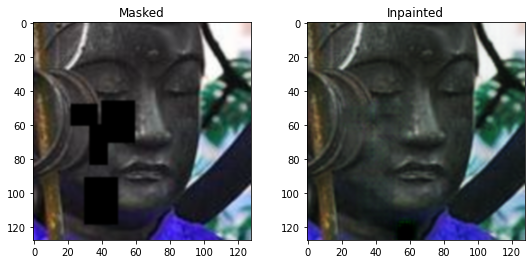

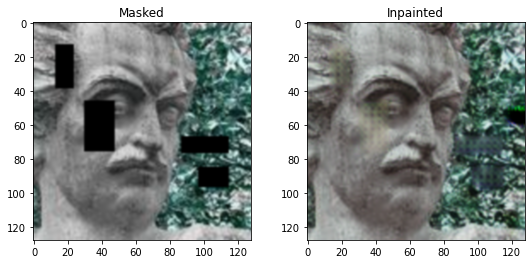

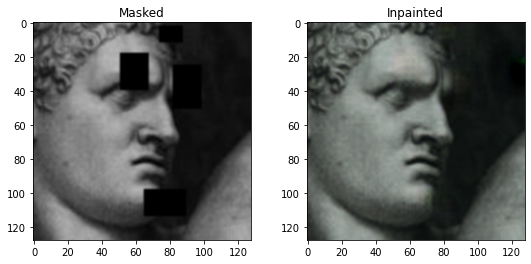

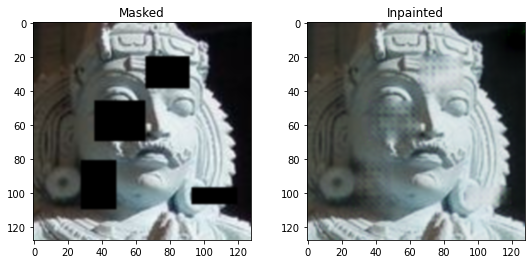

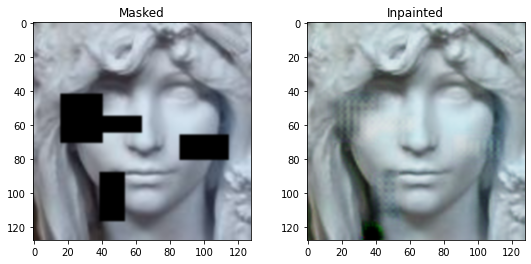

In [ ]:
images_test, landmarks_test, masks_test = next(iter(train_loader))
from torchvision import transforms

landmark_map_test = torch.zeros((config.BATCH_SIZE, 1, config.INPUT_SIZE, config.INPUT_SIZE))
for i in range(landmarks_test.shape[0]):
  landmark_map_test[i,0,landmarks_test.cpu().data.numpy()[i,0:68,1],landmarks_test.cpu().data.numpy()[i,0:68,0]] = 1


if True:
  results_test = inpaint_model(images_test.float().cuda(), landmark_map_test.float().cuda(), masks_test.float().cuda())
  print('Model run succeeded')
  for i, img in enumerate(results_test[:5]):
    f = plt.figure(figsize=(9, 4))
    img = images_test[i].cpu()
    lmk = landmarks_test[i].cpu()
    msk = masks_test[i].cpu()
    masked_img = img * (1 - msk)
    ax1 = f.add_subplot(1,2, 1)
    ax1.set_title('Masked')
    plt.imshow(transforms.ToPILImage()(masked_img), interpolation="bicubic")


    ax2 = f.add_subplot(1,2, 2)
    ax2.set_title('Inpainted')    
    inpainted_img = results_test[i].detach()
    plt.imshow(transforms.ToPILImage()(inpainted_img), interpolation="bicubic")
    plt.show(block=True)

## Check on Test Images

Model run succeeded


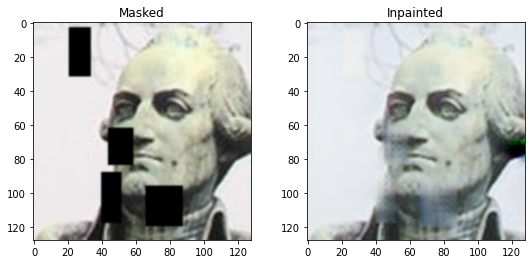

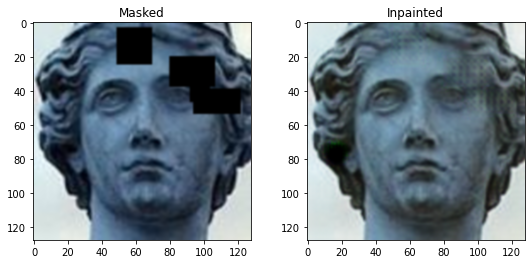

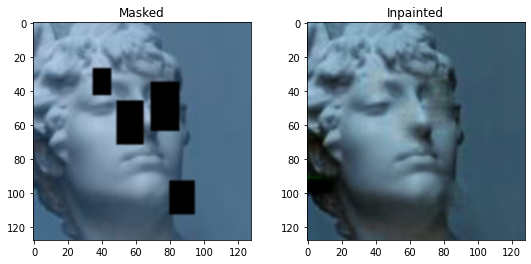

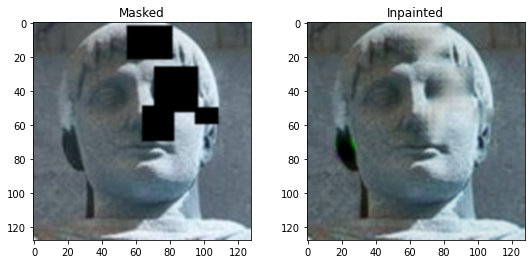

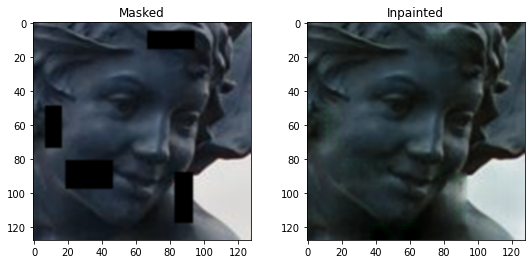

In [ ]:
images_test, landmarks_test, masks_test = next(iter(test_loader))
from torchvision import transforms

landmark_map_test = torch.zeros((config.BATCH_SIZE, 1, config.INPUT_SIZE, config.INPUT_SIZE))
for i in range(landmarks_test.shape[0]):
  landmark_map_test[i,0,landmarks_test.cpu().data.numpy()[i,0:68,1],landmarks_test.cpu().data.numpy()[i,0:68,0]] = 1


if True:
  results_test = inpaint_model(images_test.float().cuda(), landmark_map_test.float().cuda(), masks_test.float().cuda())
  print('Model run succeeded')
  for i, img in enumerate(results_test[:5]):
    f = plt.figure(figsize=(9, 4))
    img = images_test[i].cpu()
    lmk = landmarks_test[i].cpu()
    msk = masks_test[i].cpu()
    masked_img = img * (1 - msk)
    ax1 = f.add_subplot(1,2, 1)
    ax1.set_title('Masked')
    plt.imshow(transforms.ToPILImage()(masked_img), interpolation="bicubic")


    ax2 = f.add_subplot(1,2, 2)
    ax2.set_title('Inpainted')    
    inpainted_img = results_test[i].detach()
    plt.imshow(transforms.ToPILImage()(inpainted_img), interpolation="bicubic")
    plt.show(block=True)

In [ ]:
inpaint_model.save()


saving Inpainting...



Model run succeeded


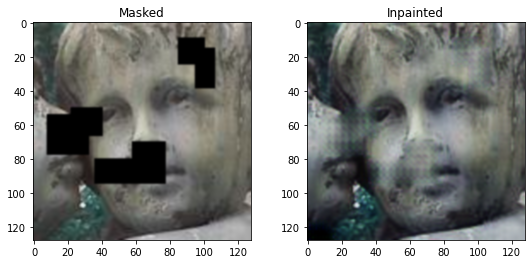

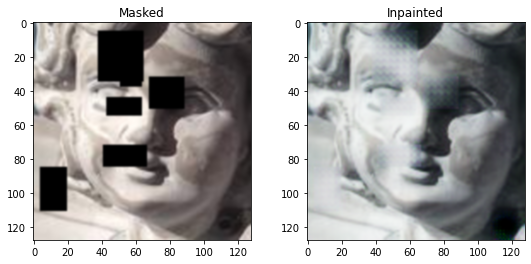

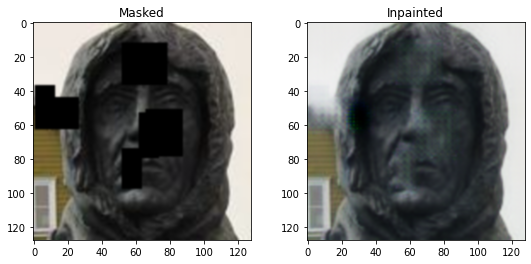

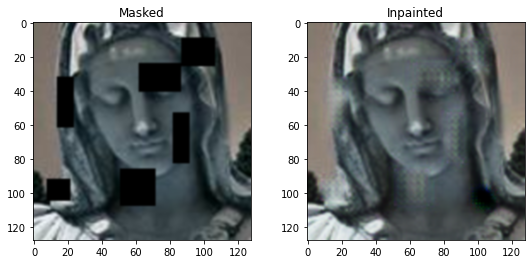

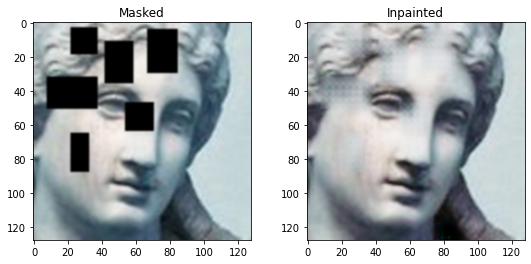

In [ ]:


images_test, landmarks_test, masks_test = next(iter(torch.utils.data.DataLoader(
    InpaintingDataset(train = False, masks_number=6), 
    batch_size=config.BATCH_SIZE, shuffle=True
)))
from torchvision import transforms

landmark_map_test = torch.zeros((config.BATCH_SIZE, 1, config.INPUT_SIZE, config.INPUT_SIZE))
for i in range(landmarks_test.shape[0]):
  landmark_map_test[i,0,landmarks_test.cpu().data.numpy()[i,0:68,1],landmarks_test.cpu().data.numpy()[i,0:68,0]] = 1


if True:
  results_test = inpaint_model(images_test.float().cuda(), landmark_map_test.float().cuda(), masks_test.float().cuda())
  print('Model run succeeded')
  for i, img in enumerate(results_test[:5]):
    f = plt.figure(figsize=(9, 4))
    img = images_test[i].cpu()
    lmk = landmarks_test[i].cpu()
    msk = masks_test[i].cpu()
    masked_img = img * (1 - msk)
    ax1 = f.add_subplot(1,2, 1)
    ax1.set_title('Masked')
    plt.imshow(transforms.ToPILImage()(masked_img), interpolation="bicubic")


    ax2 = f.add_subplot(1,2, 2)
    ax2.set_title('Inpainted')    
    inpainted_img = results_test[i].detach()
    plt.imshow(transforms.ToPILImage()(inpainted_img), interpolation="bicubic")
    plt.show(block=True)